# **Neural Network - Uber Fare Classification**

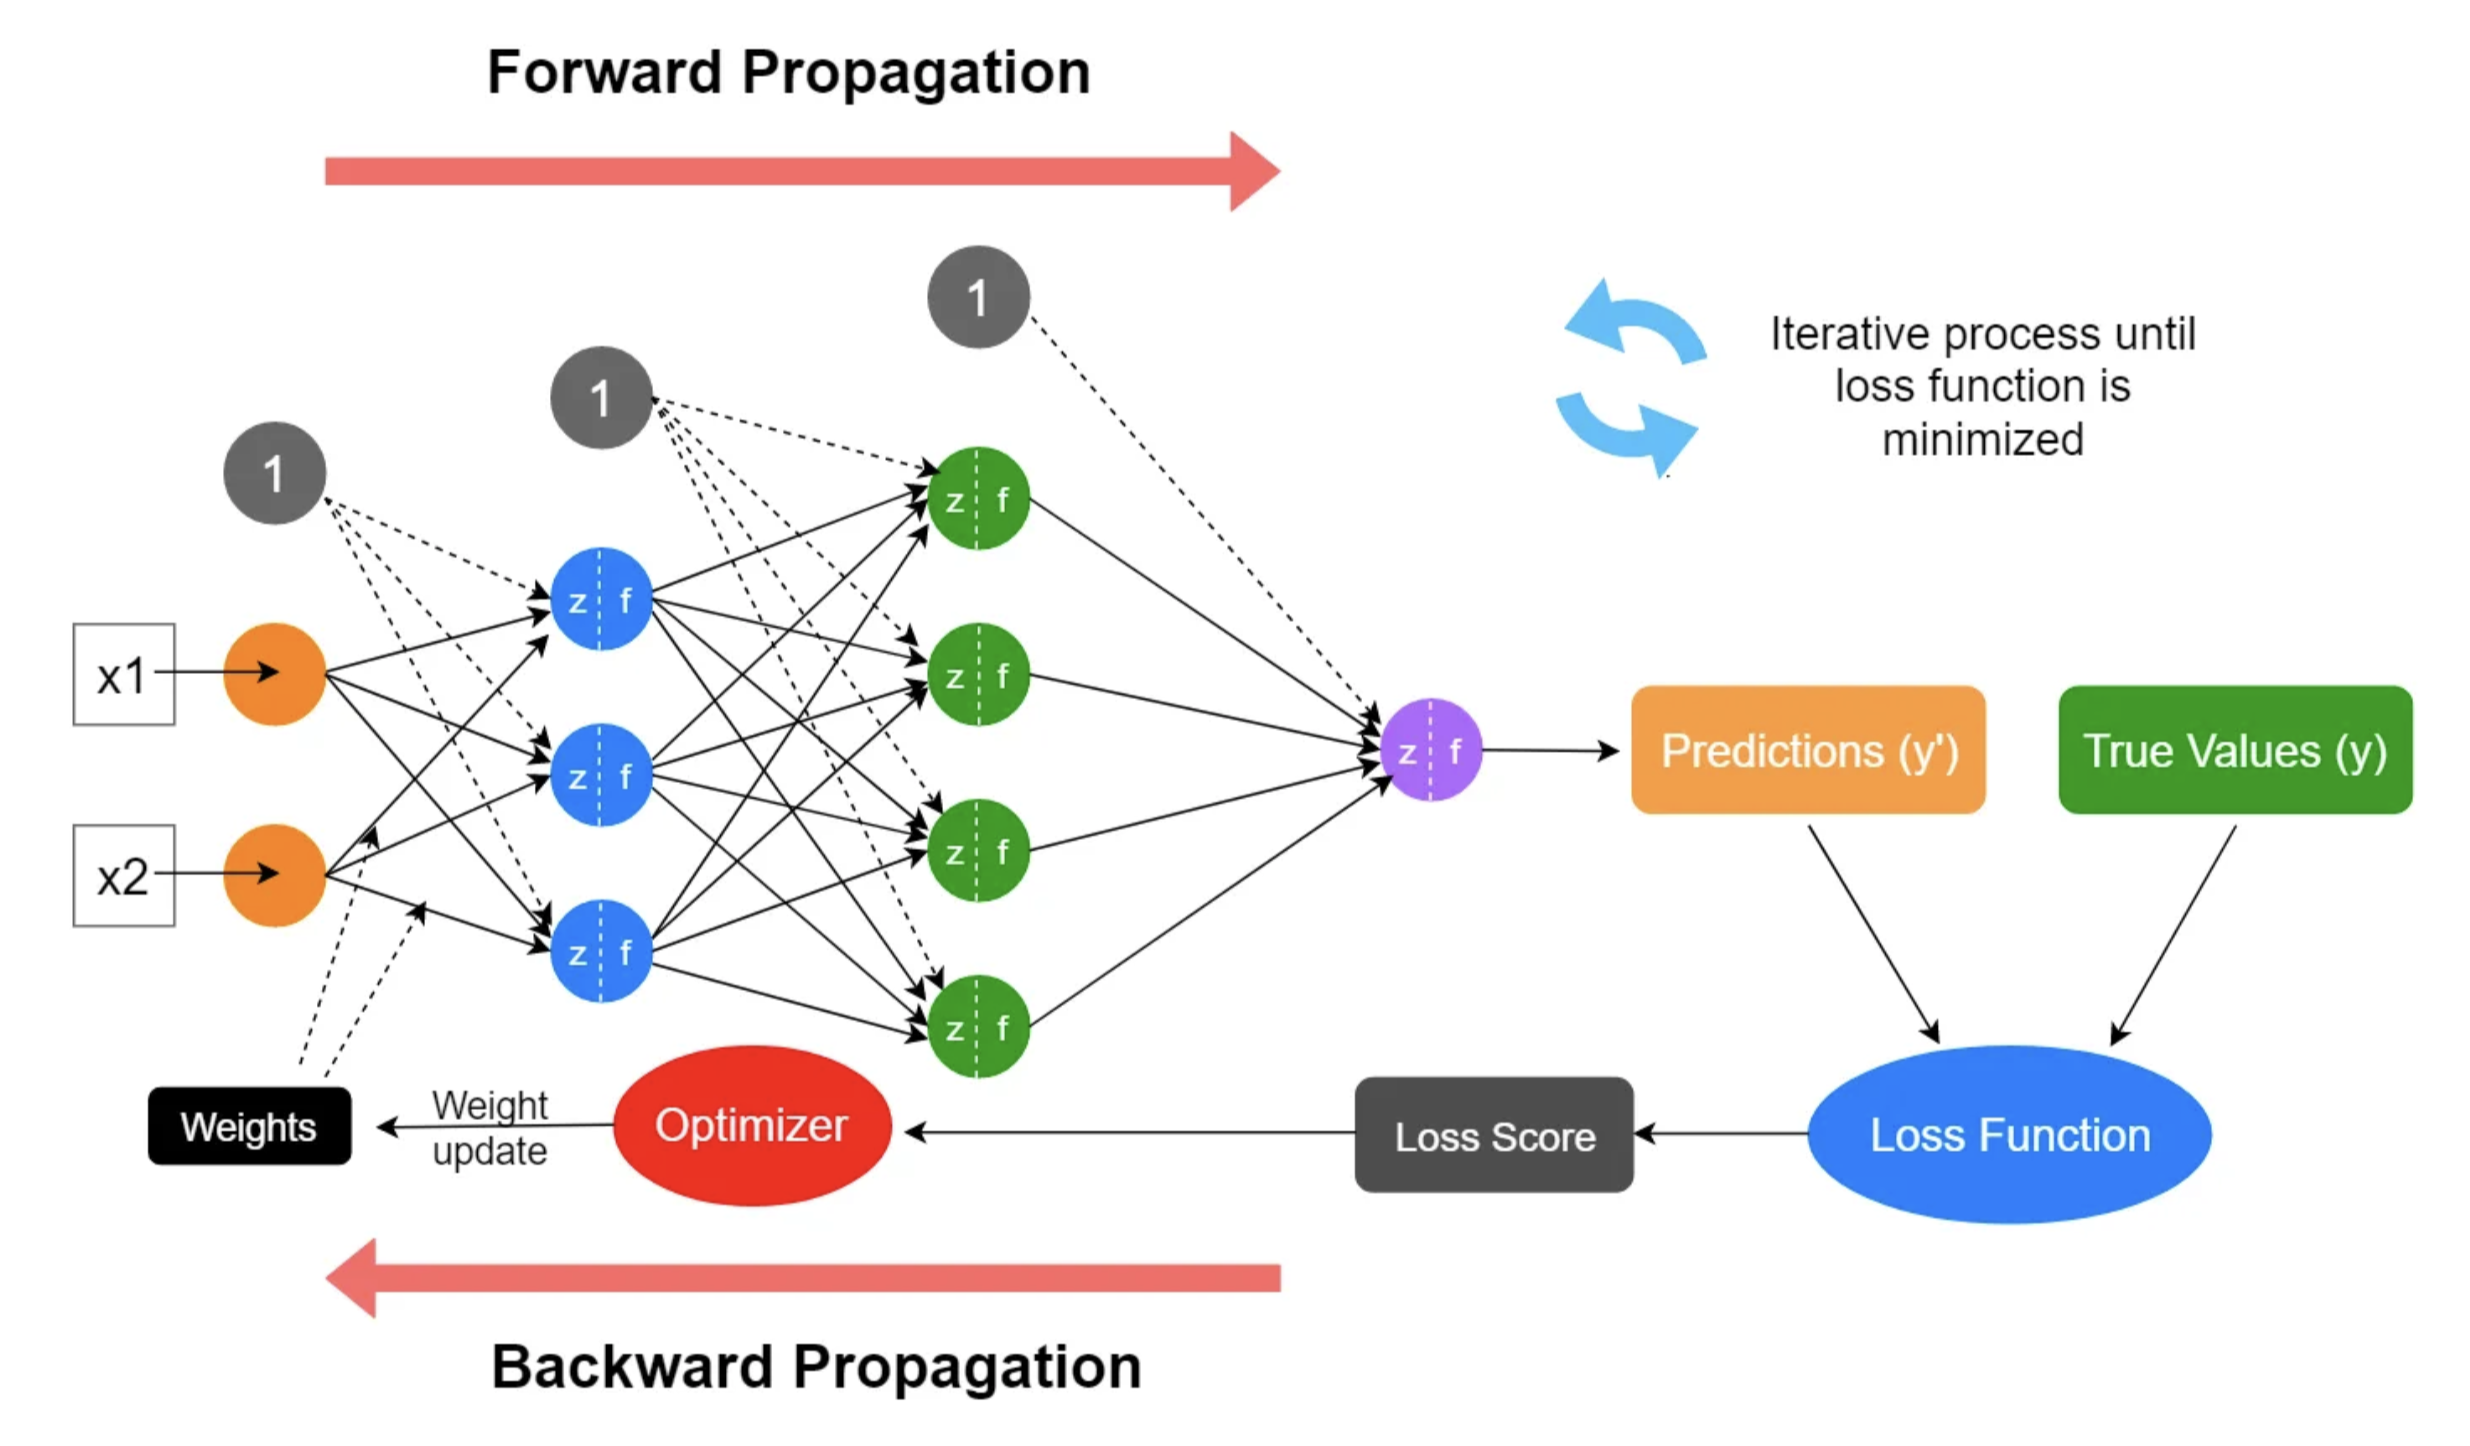

This project implements a **Simple Feedforward Neural Network** from scratch using NumPy to classify Uber rides as either **high fare** (> $15) or **low fare**.

The neural network includes:
- One hidden layer with **ReLU** activation
- A final output neuron using **sigmoid** activation
- Custom **forward and backward propagation**
- Manual **gradient descent** for weight updates

The diagram above illustrates the learning workflow:
1. **Forward Propagation**: Input features pass through weighted connections and activation functions to generate predictions.
2. **Loss Function**: The model compares predictions with actual labels using a binary loss function.
3. **Backward Propagation**: Errors are backpropagated to update weights via gradient descent.
4. This iterative loop continues until the loss is minimized.

Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 266 (delta 125), reused 138 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (266/266), 9.57 MiB | 47.09 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Model A: Raw Training Data ===
Test Accuracy: 0.8220
Precision:     0.0000
Recall:        0.0000

=== Model B: Balanced Training Set (Undersampling) ===
Test Accuracy: 0.2970
Precision:     0.1915
Recall:        0.9157


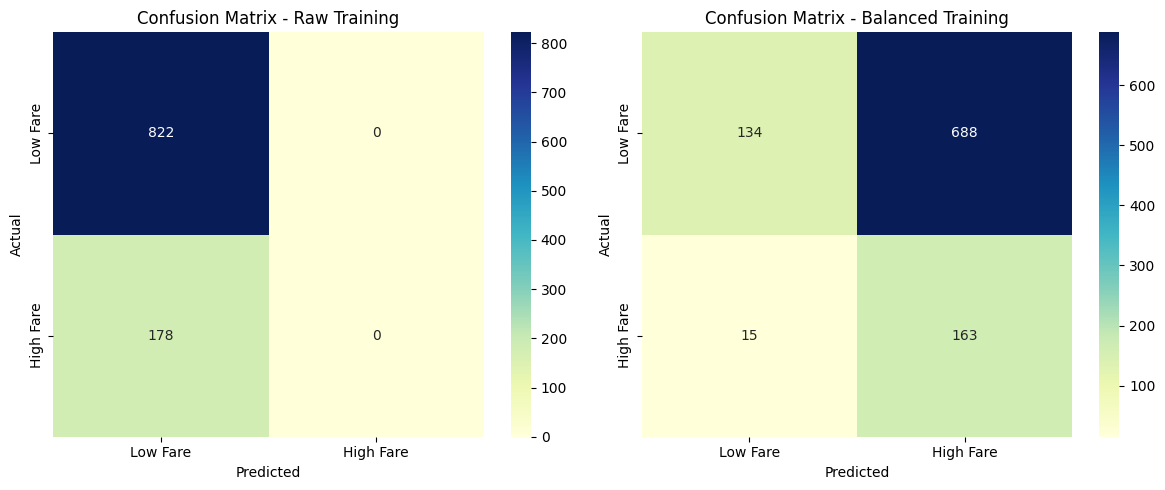

In [11]:
# %%capture
# Step 1: Clone GitHub repo and import neural network model
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

from rice_ml.neural_network import SimpleNeuralNetwork
from rice_ml.metrics import accuracy

# Step 2: Mount Drive & Load Dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.utils import resample

# Step 3: Load and preprocess dataset
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)

df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()
df = df[df['fare_amount'] < 100]
df['label'] = (df['fare_amount'] > 15).astype(int)
df = df.sample(n=5000, random_state=42)

# Step 4: Feature engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]

X_raw = df[features].values
y = df['label'].values

# Step 5: Standardize and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==========================
# Model A: Train on raw data
# ==========================
model_raw = SimpleNeuralNetwork(input_dim=X_train.shape[1], hidden_dim=16,
                                learning_rate=0.0005, n_iters=2000)
model_raw.fit(X_train, y_train)
y_pred_raw = model_raw.predict(X_test)
acc_raw = accuracy(y_test, y_pred_raw)
precision_raw = precision_score(y_test, y_pred_raw, zero_division=0)
recall_raw = recall_score(y_test, y_pred_raw, zero_division=0)

# ==========================
# Model B: Train on balanced data (undersampling)
# ==========================
X_0 = X_train[y_train == 0]
y_0 = y_train[y_train == 0]
X_1 = X_train[y_train == 1]
y_1 = y_train[y_train == 1]

X_0_down, y_0_down = resample(X_0, y_0,
                              replace=False,
                              n_samples=len(y_1),
                              random_state=42)

X_balanced = np.vstack((X_0_down, X_1))
y_balanced = np.hstack((y_0_down, y_1))

model_bal = SimpleNeuralNetwork(input_dim=X_balanced.shape[1], hidden_dim=16,
                                learning_rate=0.0005, n_iters=2000)
model_bal.fit(X_balanced, y_balanced)
y_pred_bal = model_bal.predict(X_test)
acc_bal = accuracy(y_test, y_pred_bal)
precision_bal = precision_score(y_test, y_pred_bal, zero_division=0)
recall_bal = recall_score(y_test, y_pred_bal, zero_division=0)

# ==========================
# Compare results
# ==========================
print("=== Model A: Raw Training Data ===")
print(f"Test Accuracy: {acc_raw:.4f}")
print(f"Precision:     {precision_raw:.4f}")
print(f"Recall:        {recall_raw:.4f}\n")

print("=== Model B: Balanced Training Set (Undersampling) ===")
print(f"Test Accuracy: {acc_bal:.4f}")
print(f"Precision:     {precision_bal:.4f}")
print(f"Recall:        {recall_bal:.4f}")

# ==========================
# Confusion Matrices
# ==========================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_raw = confusion_matrix(y_test, y_pred_raw)
cm_bal = confusion_matrix(y_test, y_pred_bal)

sns.heatmap(cm_raw, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0],
            xticklabels=["Low Fare", "High Fare"],
            yticklabels=["Low Fare", "High Fare"])
axes[0].set_title("Confusion Matrix - Raw Training")

sns.heatmap(cm_bal, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1],
            xticklabels=["Low Fare", "High Fare"],
            yticklabels=["Low Fare", "High Fare"])
axes[1].set_title("Confusion Matrix - Balanced Training")

for ax in axes:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


# **Raw vs. Balanced Training: How Undersampling Enhances Recall in Imbalanced Classification**

The comparison between the two neural network models highlights the trade-off between overall accuracy and class-specific performance. The model trained on the raw, imbalanced dataset (Model A) achieved high accuracy (82.2%) but completely failed to detect any high-fare rides, resulting in precision and recall both equal to 0. In contrast, the model trained on a balanced dataset using undersampling (Model B) drastically improved its ability to identify high-fare cases, achieving a recall of 91.6% and a precision of 19.2%. Although this came at the cost of lower overall accuracy (29.7%), it demonstrates that undersampling helps correct severe class bias and allows the model to meaningfully detect the minority class, which is critical in applications where recall for rare but important events matters more than raw accuracy.